In [1]:
# Imports
import datetime
import pandas_profiling
import psycopg2 as pg
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.image as mpimg
import matplotlib.colors as mcolors

from matplotlib import pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.basemap import Basemap

In [2]:
# Display options
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 6)
pd.options.mode.chained_assignment = None  # default='warn'

plt.rcParams["figure.figsize"] = (12, 8)
sns.set(style="whitegrid", color_codes=True)
sns.set_context("notebook", font_scale=1.2)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [232]:
# Get data from db
connection = pg.connect(host='rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net',
                        port=6432,
                        dbname='hr-analytics',
                        sslmode='require',
                        user='analytics',
                        password='HRanalytics')

orders = pd.io.sql.read_sql('SELECT * FROM orders;', connection)
delivery_windows = pd.io.sql.read_sql('SELECT * FROM delivery_windows;', connection)
stores = pd.io.sql.read_sql('SELECT * FROM stores;', connection)
addresses = pd.io.sql.read_sql('SELECT * FROM addresses;', connection)
replacements = pd.io.sql.read_sql('SELECT * FROM replacements;', connection)
cancellations = pd.io.sql.read_sql('SELECT * FROM cancellations;', connection)

In [5]:
# Save data
orders.to_csv('orders.csv', index=False)
delivery_windows.to_csv('delivery_windows.csv', index=False)
stores.to_csv('stores.csv', index=False)
addresses.to_csv('addresses.csv', index=False)
replacements.to_csv('replacements.csv', index=False)
cancellations.to_csv('cancellations.csv', index=False)

In [3]:
# Get data from files
orders = pd.read_csv('orders.csv')
delivery_windows = pd.read_csv('delivery_windows.csv')
stores = pd.read_csv('stores.csv')
addresses = pd.read_csv('addresses.csv')
replacements = pd.read_csv('replacements.csv')
cancellations = pd.read_csv('cancellations.csv')

In [4]:
# Marker total cost bed data
orders['bed_total_cost'] = False
orders.loc[orders[orders['total_cost']<0].index, 'bed_total_cost'] = True

In [5]:
# Marker total quantity bed data
orders['bed_quantity'] = False
orders.loc[orders['total_quantity']==0, 'bed_quantity'] = True

In [6]:
# Marker delivery window bed data
orders['bed_delivery_window'] = False
orders.loc[orders['delivery_window_id'].isna(), 'bed_delivery_window'] = True

In [7]:
# Convert time data
orders['shipped_at'] = pd.to_datetime(orders['shipped_at'])
orders['created_at'] = pd.to_datetime(orders['created_at'])

In [8]:
# Count delivery promo sum
orders['delivery_promo_sum'] = orders['cost']-orders['total_cost']

In [9]:
# Count shipped time
orders['shipped_time'] = orders['shipped_at']-orders['created_at']
orders['shipped_time_days'] = orders['shipped_time'].dt.days
orders['shipped_time_hour'] = orders['shipped_time'].dt.total_seconds()/3600

In [10]:
# Count mean item price
orders['mean_item_price'] = 0 
orders.loc[orders['bed_quantity'] ==False ,'mean_item_price'] = orders['item_total']/orders['total_quantity']

In [11]:
# Add stores data to orders
stores.columns = ['store_id', 'store_city', 'retailer_id']
orders = pd.merge(orders, stores, how='left', on='store_id')

In [12]:
# Add addresses data to orders
addresses.columns = ['lat', 'lon', 'ship_address_id', 'elevator', 'floor']
orders = pd.merge(orders, addresses, how='left', on='ship_address_id')

In [13]:
# Add delivery windows data to orders
delivery_windows.columns = ['store_id_from_delivery', 'delivery_window_id', 'start_delivery', 'end_delivery', 'time']
delivery_windows = delivery_windows[['delivery_window_id', 'start_delivery', 'end_delivery']]
orders = pd.merge(orders, delivery_windows, how='left', on='delivery_window_id').drop_duplicates().reset_index(drop=True)
# Marker coordinats bed data
orders['bed_coordinats'] = False
orders.loc[orders['lon']==0, 'bed_coordinats'] = True
# Replace bed coordinats to mean coordinats
orders.loc[orders['lon']==0, 'lon'] = orders['lon'].mean()
orders.loc[orders['lat']==0, 'lat'] = orders['lat'].mean()

In [14]:
# Get Russian towns data with coordinats from file
russian_towns = pd.read_table('russian_towns.tsv')
russian_towns = russian_towns[['name', 'lon', 'lat', 'west', 'south', 'east', 'north']]
russian_towns = russian_towns.query('lon<74 and lon>37 and lat>53 and lat<57')
russian_towns = russian_towns[russian_towns['lon']!=russian_towns['west']]
russian_towns.reset_index(drop=True, inplace=True)

In [15]:
# Add order city name to orders by coordinats
orders['order_city'] = None
city_ = {}
for ind in russian_towns.index:
    temp_df = orders[(orders['lat']>russian_towns.loc[ind,'south']) & \
              (orders['lat']<russian_towns.loc[ind,'north']) & \
              (orders['lon']>russian_towns.loc[ind,'west']) & \
              (orders['lon']<russian_towns.loc[ind,'east'])]
    if len(temp_df.index)!=0:
        city_[russian_towns.loc[ind, 'name']] = temp_df.index

for city_name, orders_id in city_.items():
    orders.loc[orders_id, 'order_city'] = city_name

In [16]:
# Add store city name
store_city_dict = {}
for store_city_id in orders[orders['store_city']!=False]['store_city'].value_counts().index:
    store_city_dict[store_city_id] = orders[orders['store_city'] == store_city_id]['order_city'].value_counts().index[0]
orders['store_city_name'] = orders['store_city'].map(store_city_dict)
orders.loc[orders['store_city_name'].isna(), 'store_city_name'] = False

In [17]:
# Prepare orders city data to draw
count_by_city = orders['order_city'].value_counts().to_frame().reset_index(drop=False)
count_by_city.columns = ['name', 'count_orders']
count_by_city = pd.merge(count_by_city, russian_towns[['name','lon','lat']], how='left', left_on='name', right_on='name')

In [18]:
# Prepare stores city data to draw
count_by_city_stores = orders[orders['store_city_name']!=False]['store_city_name'].value_counts().to_frame().reset_index(drop=False)
count_by_city_stores.columns = ['name', 'count_orders']
count_by_city_stores = pd.merge(count_by_city_stores, russian_towns[['name','lon','lat']], how='left', left_on='name', right_on='name')

In [19]:
# Moscow region extrem coordinats 54.25 - 56.96;  35.13 - 40.18
# Prepare stores city and orders city data for Moscow region
count_by_city_mo = count_by_city[(count_by_city['lon']>35.13) &\
                                 (count_by_city['lon']<40.18) &\
                                 (count_by_city['lat']>54.25) &\
                                 (count_by_city['lon']<56.96)]
count_by_city_stores_mo = count_by_city_stores[(count_by_city_stores['lon']>35.13) &\
                                               (count_by_city_stores['lon']<40.18) &\
                                               (count_by_city_stores['lat']>54.25) &\
                                               (count_by_city_stores['lon']<56.96)]

In [20]:
# Draw orders city and stores city (depend on size square) on map
def drow_map(df, df_1, len_write, border, scale):
    lats = df['lat'][:]
    lons = df['lon'][:]
    lats_t = df['lat'][:len_write]
    lons_t = df['lon'][:len_write]
    size = df['count_orders'][:]/scale
    
    lats_1 = df_1['lat'][:]
    lons_1 = df_1['lon'][:]
    lats_t_1 = df_1['lat'][:len_write]
    lons_t_1 = df_1['lon'][:len_write]
    size_1 = df_1['count_orders'][:]/scale

    plt.figure(figsize=(16,8))
    m = Basemap(
                llcrnrlon=df['lon'].min()-border,
                llcrnrlat=df['lat'].min()-border,
                urcrnrlon=df['lon'].max()+border,
                urcrnrlat=df['lat'].max()+border,
                lat_0 =df['lat'].mean(),
                lon_0 = df['lon'].mean())
    x, y = m(lons,lats)
    x_1, y_1 = m(lons_1,lats_1)
    m.drawmapboundary(fill_color='#ebffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff', alpha=0.1)
    m.scatter(x, y, size, marker='s',facecolors='none', edgecolors='#48b0b0', linewidths=2, alpha=0.8, label = 'orders locations')
    m.scatter(x_1, y_1, size_1, marker='s',facecolors='none', edgecolors='m', linewidths=2, alpha=0.8, label = 'stores locations')
    for ind, x, y in zip(df[:len_write].index, lons_t, lats_t):
        plt.text(x, y, df.loc[ind, 'name'], c='#48b0b0', fontsize=16)
    for ind, x_1, y_1 in zip(df_1[:len_write].index, lons_t_1, lats_t_1):
        plt.text(x_1, y_1, df_1.loc[ind, 'name'], c ='m', fontsize=16)

    plt.legend(loc=1, markerscale=0.1)
    plt.title('Bigest orders and stores locations',fontsize=12)
    plt.show()

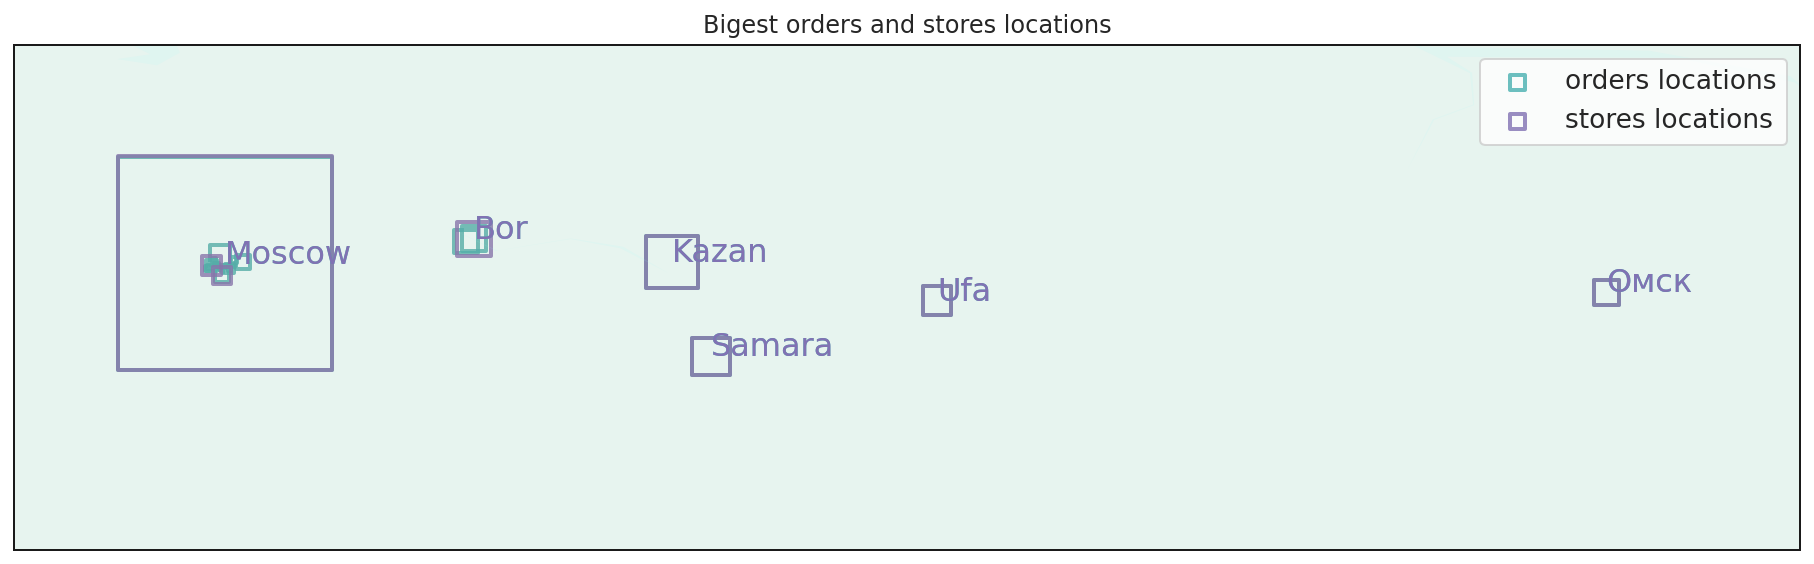

In [21]:
# Russia
drow_map(count_by_city, count_by_city_stores, 6, 5, 25)

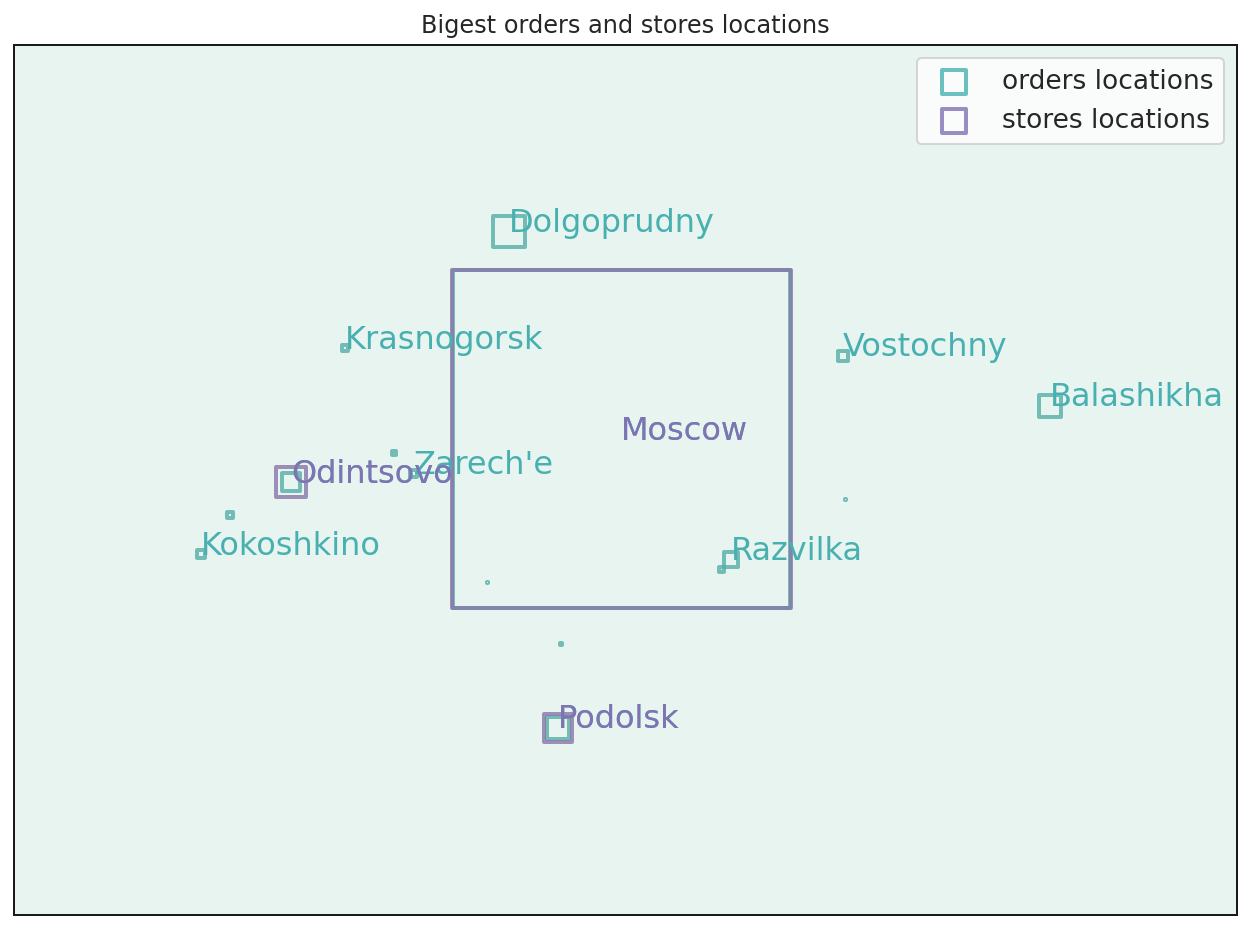

In [22]:
# Moscow region
drow_map(count_by_city_mo, count_by_city_stores_mo, 10, 0.2, 10)

In [23]:
# Show best citys for stores
top_4_best_city_for_store = list(set(count_by_city.loc[0:11, 'name']) - set(count_by_city_stores.loc[:, 'name']))
top_4_best_city_for_store.remove('Nizhny Novgorod')
top_3_best_city_for_store = top_4_best_city_for_store
top_3_best_city_for_store

['Balashikha', 'Dolgoprudny', 'Razvilka']

In [24]:
# Add replace and cancel items data 
replacements_key_id = replacements.groupby('order_id')['item_id'].apply(list)
replacements_key_id = replacements_key_id.to_frame().reset_index(drop=False)
replacements_key_id.columns = ['id', 'replace_item_id']

cancellations_key_id = cancellations.groupby('order_id')['item_id'].apply(list)
cancellations_key_id = cancellations_key_id.to_frame().reset_index(drop=False)
cancellations_key_id.columns = ['id', 'cancel_item_id']

orders = pd.merge(orders, replacements_key_id, how='left', left_on = 'id', right_on = 'id')
orders = pd.merge(orders, cancellations_key_id, how='left', left_on = 'id', right_on = 'id')

In [25]:
# Fill unknow data False 
orders = orders.fillna(False)

In [26]:
# Add count and part replace and cancel items data
orders_ = orders.drop_duplicates(subset='id')
duplicate_index = list(set(orders.index) - set(orders_.index))
orders.loc[duplicate_index, 'replace_item_id'] = 0
orders.loc[duplicate_index, 'cancel_item_id'] = 0

orders.loc[(~orders['replace_item_id'].isna()) & (orders['replace_item_id']!=0), 'count_replace_item_id'] =\
[len(x) for x in orders.loc[(~orders['replace_item_id'].isna()) & (orders['replace_item_id']!=0)]['replace_item_id']]

orders.loc[(~orders['cancel_item_id'].isna()) & (orders['cancel_item_id']!=0), 'count_cancel_item_id'] =\
[len(x) for x in orders.loc[(~orders['cancel_item_id'].isna()) & (orders['cancel_item_id']!=0)]['cancel_item_id']]

orders['part_replace_item_id'] = orders['count_replace_item_id']/orders['total_quantity']
orders['part_cancel_item_id'] = orders['count_cancel_item_id']/orders['total_quantity']

In [27]:
# Fill unknow data 0
orders[['count_replace_item_id', 'count_cancel_item_id', 'part_replace_item_id', 'part_cancel_item_id']] = \
orders[['count_replace_item_id', 'count_cancel_item_id', 'part_replace_item_id', 'part_cancel_item_id']].fillna(0)

In [28]:
# Convert time data and count delivery time
orders.loc[orders['bed_delivery_window']!=True,'start_delivery'] = pd.to_datetime(orders[orders['bed_delivery_window']!=True]['start_delivery'])
orders.loc[orders['bed_delivery_window']!=True, 'end_delivery'] = pd.to_datetime(orders[orders['bed_delivery_window']!=True]['end_delivery'])

orders['delivery_time'] = orders['end_delivery'] - orders['start_delivery']
orders.loc[orders['bed_delivery_window']!=True, 'delivery_time_hour'] =\
[x.total_seconds()/3600 for x in orders[orders['bed_delivery_window']!=True]['delivery_time']]

In [29]:
# Marker correct delivery window
orders_ = orders[orders['bed_delivery_window']!=True]
orders_.loc[(orders_['start_delivery']<orders_['shipped_at']) & (orders_['end_delivery']>orders_['shipped_at']), 'correct_delivery_window'] = True

orders.loc[orders_.index, 'correct_delivery_window'] = orders_['correct_delivery_window']
orders.loc[orders['correct_delivery_window'].isna(), 'correct_delivery_window'] = False

In [30]:
# Marker bed end delivery
orders['bed_end_delivery'] = orders['end_delivery'].apply(lambda x: not isinstance(x, datetime.datetime))

In [31]:
# Marker parts per order
parts_per_order = orders.groupby('id').count()['user_id'].to_frame().rename(columns = {'user_id':'parts_per_order'})
orders = pd.merge(orders, parts_per_order, how = 'left', left_on='id', right_on='id')
orders['parts_per_order'].value_counts()

1    333087
2      1146
3        12
Name: parts_per_order, dtype: int64

In [32]:
print('composite cargo percent: ', (1146+12)/(333087+1146+12)*100, "%")

composite cargo percent:  0.34645245254229684 %


In [33]:
# Count full cost
orders['full_cost'] = orders['total_cost'] + orders['item_total'] + orders['promo_total']

In [34]:
# Count delivery part, promo delivery part,  promo item part
orders['delivery_part'] = orders['total_cost']/orders['full_cost']
orders['promo_delivery_part'] = orders['delivery_promo_sum']/orders['full_cost']
orders['promo_item_part'] = -orders['promo_total']/orders['full_cost']

In [35]:
# Count user activity
user_activity = orders[orders['parts_per_order']==1].groupby('user_id')[['total_quantity','full_cost']].sum()
period = (orders['created_at'].max()-orders['created_at'].min()).days/365
user_activity['total_quantity_per_year'] = user_activity['total_quantity']/period
user_activity['full_cost_per_year'] = user_activity['full_cost']/period

orders = pd.merge(orders, user_activity[['total_quantity_per_year', 'full_cost_per_year']],\
         how="left", left_on='user_id', right_on='user_id')

In [36]:
# save
orders_ = orders.copy()
orders_.shape

(334245, 50)

In [37]:
# Filter bed data
orders = orders[~((orders['bed_total_cost']==True) |\
                  (orders['bed_quantity']==True) |\
                  (orders['bed_delivery_window']==True) |\
                  (orders['bed_coordinats']==True) |\
                  (orders['bed_end_delivery']==True))]

orders = orders[['id', 'user_id', 'item_total', 'promo_total', 
       'total_weight', 'total_quantity', 'state', 
       'store_id', 'total_cost',
       'shipped_time_hour', 'mean_item_price', 'retailer_id', 'elevator', 'order_city',
       'store_city_name', 'count_replace_item_id', 'count_cancel_item_id', 'part_replace_item_id',
       'part_cancel_item_id', 'delivery_time_hour',
       'correct_delivery_window', 'parts_per_order',
       'full_cost', 'delivery_part', 'promo_delivery_part', 'promo_item_part',
       'total_quantity_per_year', 'full_cost_per_year']]

In [38]:
orders.shape

(334201, 28)

In [39]:
# bed data %
(orders_.shape[0] - orders.shape[0])/orders_.shape[0]*100

0.013163996469655492

In [40]:
# Correct False elevator and False retailer_id
orders.loc[orders['elevator']==False, 'elevator'] = 'no'
orders.loc[orders['retailer_id']==False, 'retailer_id'] = 0

In [41]:
# Encode order_city and store_city, marker same city 
city_dict = dict(zip(orders['order_city'].value_counts().index.to_list(),\
         [*range(len(orders['order_city'].value_counts().index))]))

orders['order_city_id'] = orders['order_city'].map(city_dict)
orders['store_city_id'] = orders['store_city_name'].map(city_dict)
orders['same_city'] = list(orders['order_city_id'] == orders['store_city_id'])
same_city = orders['same_city'].value_counts()

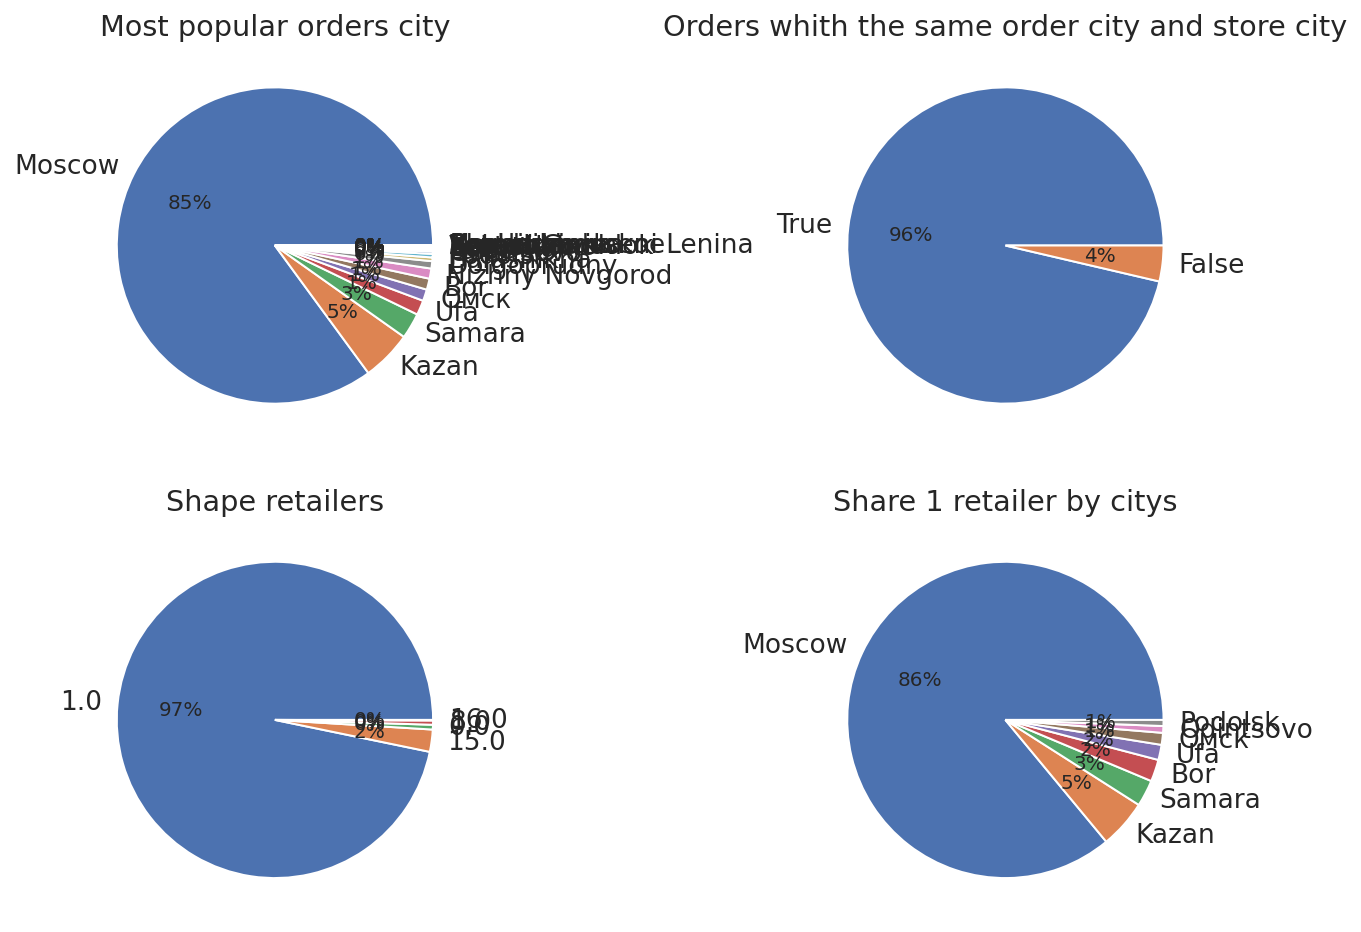

In [42]:
# Plot citys info
fig = plt.figure(figsize = (12,8))
plt.subplot(2, 2, 1)
orders['order_city'].value_counts().plot(kind='pie', autopct='%1.0f%%').set_ylabel('')
plt.title('Most popular orders city')

plt.subplot(2, 2, 2)
same_city.plot(kind='pie', autopct='%1.0f%%').set_ylabel('')
plt.title('Orders whith the same order city and store city')

plt.subplot(2, 2, 3)
retailer_id = orders['retailer_id'].value_counts()
retailer_id.plot(kind='pie', autopct='%1.0f%%').set_ylabel('')
plt.title('Shape retailers')

plt.subplot(2, 2, 4)
retailer_1 = orders[orders['retailer_id']==1]['store_city_name'].value_counts()
retailer_1.plot(kind='pie', autopct='%1.0f%%', ylabel=False).set_ylabel('')
plt.title('Share 1 retailer by citys')

plt.show()

In [43]:
# Encode state, elevator, correct_delivery_window, retailer_id
le = preprocessing.LabelEncoder()
orders[['state', 'elevator', 'correct_delivery_window', 'retailer_id']] =\
orders[['state', 'elevator', 'correct_delivery_window', 'retailer_id']].apply(le.fit_transform)

In [44]:
corr = orders.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,user_id,item_total,promo_total,total_weight,total_quantity,state,store_id,total_cost,shipped_time_hour,mean_item_price,retailer_id,elevator,count_replace_item_id,count_cancel_item_id,part_replace_item_id,part_cancel_item_id,delivery_time_hour,correct_delivery_window,parts_per_order,full_cost,delivery_part,promo_delivery_part,promo_item_part,total_quantity_per_year,full_cost_per_year,order_city_id,store_city_id,same_city
id,1.000000,0.680797,0.053969,0.008692,-0.011416,0.032607,0.006585,0.220934,-0.130123,-0.071895,0.015920,-0.005175,0.046143,-0.056946,-0.124050,-0.072296,-0.106591,-0.012219,0.039398,-0.030514,0.050144,-0.033497,0.016656,0.000511,-0.033273,-0.036712,0.182572,0.150147,-0.050215
user_id,0.680797,1.000000,-0.015805,-0.033342,-0.064593,-0.032596,0.004030,0.274586,-0.322709,-0.042369,0.041429,-0.003519,0.019872,-0.079010,-0.092787,-0.041466,-0.051004,-0.034396,0.015266,-0.018029,-0.027786,-0.054243,0.026239,0.001419,-0.116671,-0.159808,0.217721,0.204092,-0.079479
item_total,0.053969,-0.015805,1.000000,-0.089233,0.558112,0.593223,-0.002384,-0.077015,0.199425,0.001308,0.160539,-0.039771,0.023011,0.167396,0.099488,-0.061733,-0.084537,0.192365,-0.017936,-0.011805,0.997885,-0.052764,-0.017359,-0.001237,0.281666,0.356276,-0.037147,-0.048053,0.025186
promo_total,0.008692,-0.033342,-0.089233,1.000000,-0.011734,-0.015474,0.008447,-0.000505,0.058744,-0.009022,-0.209815,0.012613,-0.018683,-0.042153,-0.077397,-0.018997,-0.031046,-0.015101,0.004406,0.005539,-0.032080,-0.012751,0.000081,-0.053098,0.018781,0.028885,-0.018093,-0.014282,0.015457
total_weight,-0.011416,-0.064593,0.558112,-0.011734,1.000000,0.631624,0.001515,-0.077726,0.289540,0.001861,-0.046229,-0.034449,0.019726,0.073857,0.023167,-0.093363,-0.100472,0.297518,-0.023506,-0.013464,0.564661,-0.008259,-0.005098,-0.001303,0.349213,0.333791,-0.040464,-0.048059,0.021954
total_quantity,0.032607,-0.032596,0.593223,-0.015474,0.631624,1.000000,0.001046,-0.051483,0.214462,-0.000848,-0.057462,-0.022464,0.002243,0.110597,0.062256,-0.088867,-0.095806,0.203179,-0.015890,-0.008258,0.597069,-0.021613,-0.008227,-0.001099,0.357128,0.359798,-0.027711,-0.034587,0.021314
state,0.006585,0.004030,-0.002384,0.008447,0.001515,0.001046,1.000000,0.001496,0.001466,0.000732,-0.000371,0.002483,0.000784,0.000489,0.001629,-0.000654,-0.001137,0.001249,0.005395,0.000436,-0.001864,0.000307,0.000174,0.000024,-0.000471,-0.000948,0.002139,-0.001024,0.000954
store_id,0.220934,0.274586,-0.077015,-0.000505,-0.077726,-0.051483,0.001496,1.000000,-0.168543,-0.012531,-0.001911,0.261209,-0.101650,0.018732,-0.001191,0.049288,0.027667,-0.102215,-0.042196,0.030931,-0.082100,-0.012658,-0.001145,0.001426,-0.049662,-0.062625,0.516429,0.635199,-0.194396
total_cost,-0.130123,-0.322709,0.199425,0.058744,0.289540,0.214462,0.001466,-0.168543,1.000000,0.022556,-0.032324,-0.016559,-0.003321,0.114366,0.076353,-0.016109,-0.042877,0.155602,0.007340,-0.009134,0.233570,0.132939,-0.031890,-0.002708,0.184967,0.207551,-0.114508,-0.123300,0.051443
shipped_time_hour,-0.071895,-0.042369,0.001308,-0.009022,0.001861,-0.000848,0.000732,-0.012531,0.022556,1.000000,-0.008743,-0.008358,-0.017714,0.023574,0.046423,0.013062,0.026108,0.004247,0.004919,0.002871,0.001521,0.004400,-0.002437,0.000489,-0.020970,-0.029400,0.000827,-0.009565,-0.001430


In [45]:
# Clean data
weight_low = orders['total_weight'].quantile(0.01)
weight_hi  = orders['total_weight'].quantile(0.99)

quantity_low = orders['total_quantity'].quantile(0.01)
quantity_hi  = orders['total_quantity'].quantile(0.99)

cost_low = orders['item_total'].quantile(0.01)
cost_hi  = orders['item_total'].quantile(0.99)

df = orders[(orders['total_weight'] < weight_hi) & (orders['total_weight'] > weight_low) &\
           (orders['total_quantity'] < quantity_hi) & (orders['total_quantity'] > quantity_low) &\
           (orders['item_total'] < cost_hi) & (orders['item_total'] > cost_low)]

weight = df['total_weight']
quantity = df['total_quantity']
cost = df['item_total']

In [46]:
# Count means
mean_cost_1_etc = cost.mean()/quantity.mean() 
print(mean_cost_1_etc, 'руб./шт.')
mean_cost_1g = cost.mean()/weight.mean() 
print(mean_cost_1g, 'руб./г.')
mean_weight_1_etc = weight.mean()/quantity.mean() 
print(mean_weight_1_etc, 'г./шт.')

117.60274031285998 руб./шт.
0.18807779890927181 руб./г.
625.2877319645324 г./шт.


In [47]:
# Count weight and quantity from means 
weight_cost = weight * mean_cost_1g
quantity_cost = quantity * mean_cost_1_etc

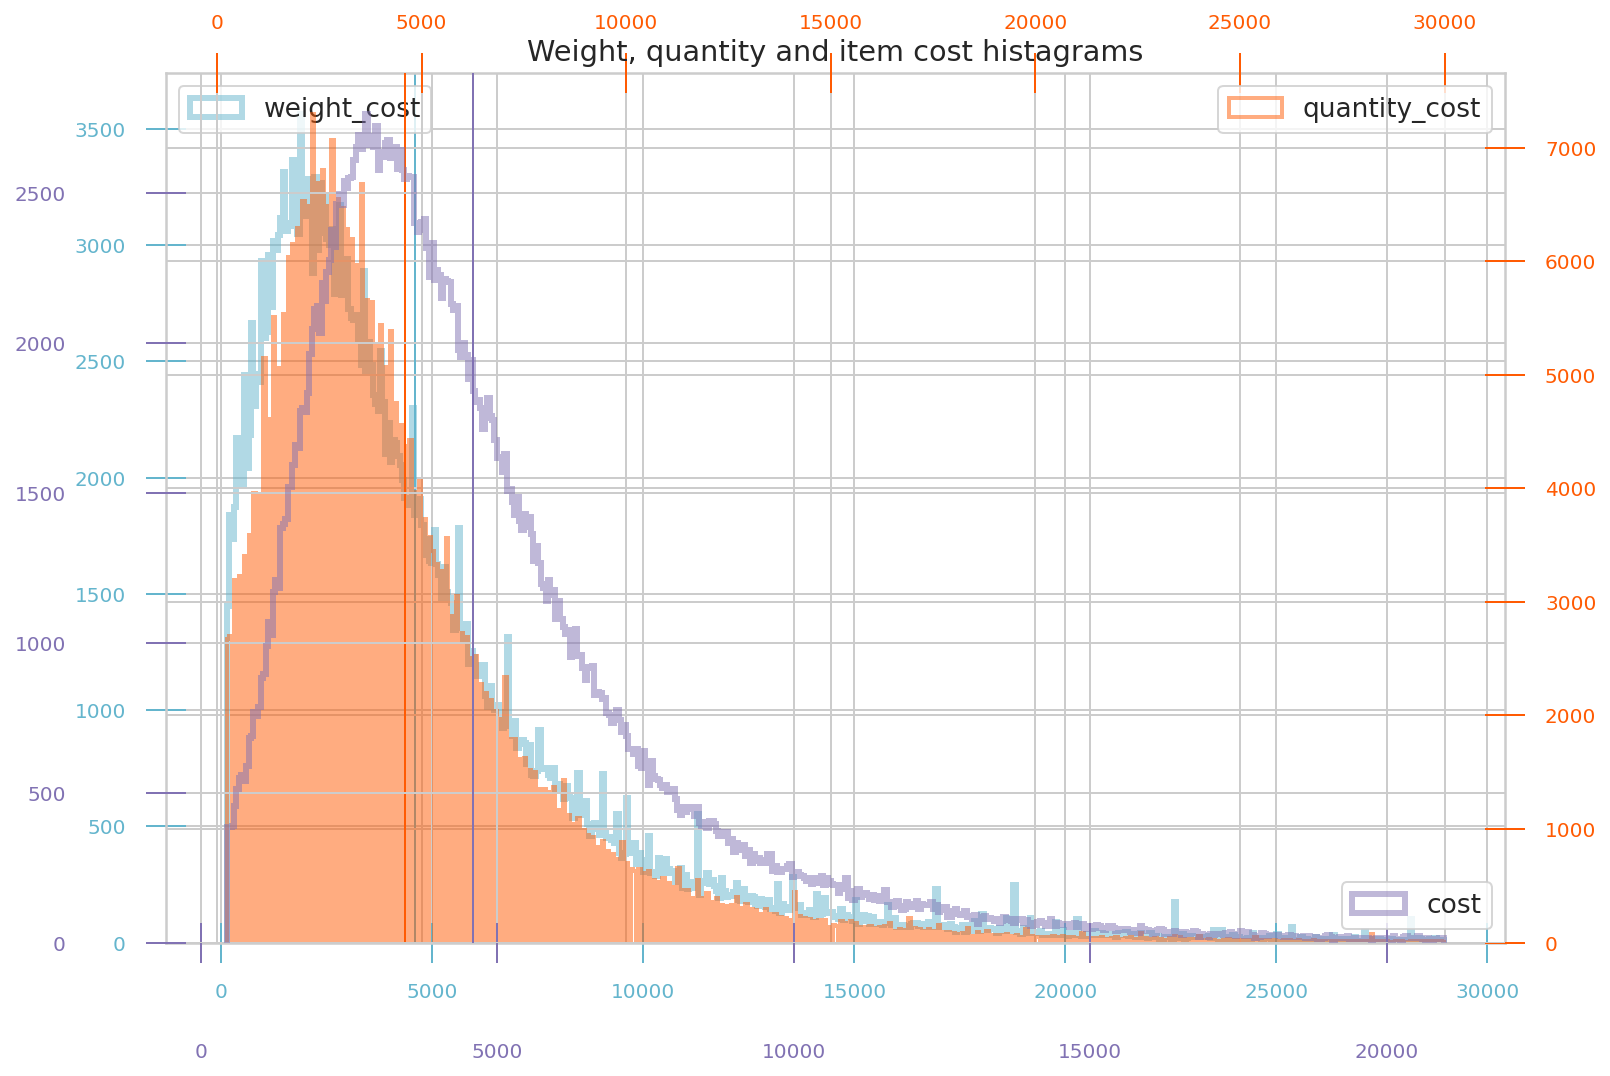

In [48]:
# Plot hist cost, weight_cost, quantity_cost
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
ax2 = fig.add_axes(ax1.get_position(), frameon=False)
ax3 = fig.add_axes(ax1.get_position(), frameon=False)


hist_w = ax1.hist(weight_cost, bins=500, color='c', alpha = 0.5, histtype='step', linewidth=3, label = 'weight_cost');
hist_q = ax2.hist(quantity_cost, bins=500, color ='#ff5b03', alpha=0.5, histtype='step', linewidth=2, label = 'quantity_cost');
hist_c = ax3.hist(cost, bins=500, color ='m', alpha=0.5, histtype='step', linewidth=3, label = 'cost');

ax1.axvline(x=weight_cost.mean(), color = 'c', linewidth=1)
ax2.axvline(x=quantity_cost.mean(), color = '#ff5b03', linewidth=1)
ax3.axvline(x=cost.mean(), color = 'm', linewidth=1)

ax1.tick_params(axis = 'both', which = 'major', direction = 'inout', length = 20, width = 1,
               color = 'c', pad = 10, labelsize = 10, labelcolor = 'c', 
               bottom = True, top = False, left = True, right = False,
               labelbottom = True, labeltop = False, labelleft = True, labelright = False,
               labelrotation = 0)
ax2.tick_params(axis = 'both', which = 'major', direction = 'inout', length = 20, width = 1,
               color = '#ff5b03', pad = 10, labelsize = 10, labelcolor = '#ff5b03', 
               bottom = False, top = True, left = False, right = True,
               labelbottom = False, labeltop = True, labelleft = False, labelright = True,
               labelrotation = 0)
ax3.tick_params(axis = 'both', which = 'major', direction = 'inout', length = 20, width = 1,
               color = 'm', pad = 40, labelsize = 10, labelcolor = 'm', 
               bottom = True, top = False, left = True, right = False,
               labelbottom = True, labeltop = False, labelleft = True, labelright = False,
               labelrotation = 0)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')
plt.title('Weight, quantity and item cost histagrams');

In [49]:
# Count tailings
weight_cost_rest = cost-weight_cost
quantity_cost_rest = cost-quantity_cost

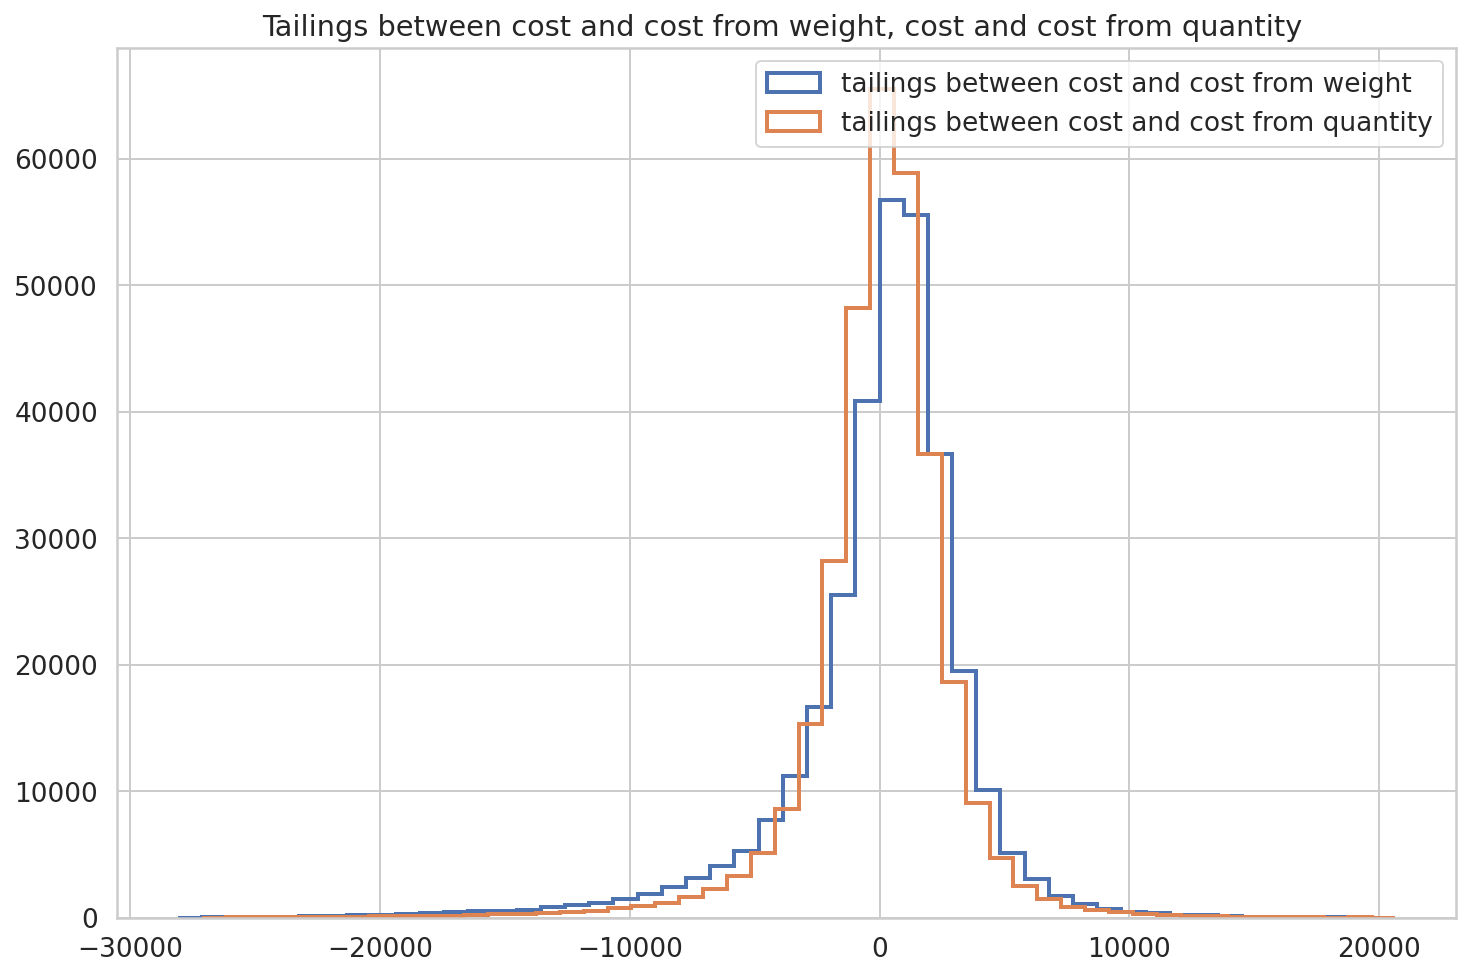

In [50]:
# Draw tailings between cost and cost from weight, cost and cost from quantity 
fig = plt.figure(figsize=(12,8))
weight_cost_rest.hist(bins=50, histtype='step', alpha=1, linewidth=2, label = 'tailings between cost and cost from weight')
quantity_cost_rest.hist(bins=50, histtype='step', alpha=1, linewidth=2, label = 'tailings between cost and cost from quantity')
plt.title('Tailings between cost and cost from weight, cost and cost from quantity ')
plt.legend();

In [51]:
# Check distribution
def get_best_distribution(data):
    dist_names = ["norm", "chi2", "gamma", "lognorm"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    print("-----------------------------")

    return best_dist, best_p, params[best_dist]

for data in [weight, quantity, cost, quantity_cost, weight_cost, weight_cost_rest, quantity_cost_rest]:
    get_best_distribution(data)

p value for norm = 0.0
p value for chi2 = 0.0
p value for gamma = 2.766992512295946e-186
p value for lognorm = 0.0
Best fitting distribution: gamma
Best p value: 2.766992512295946e-186
Parameters for the best fit: (1.3668105887235984, 648.1399749710447, 17366.539187953087)
-----------------------------
p value for norm = 0.0
p value for chi2 = 0.0
p value for gamma = 0.0
p value for lognorm = 4.827405299208146e-158
Best fitting distribution: lognorm
Best p value: 4.827405299208146e-158
Parameters for the best fit: (0.6404201313371218, -5.132059047133494, 35.97080091057192)
-----------------------------
p value for norm = 0.0
p value for chi2 = 2.723856370556981e-218
p value for gamma = 2.20914370726323e-218
p value for lognorm = 0.0
Best fitting distribution: chi2
Best p value: 2.723856370556981e-218
Parameters for the best fit: (4.616033513703838, 358.88348979441895, 915.8420639904164)
-----------------------------
p value for norm = 0.0
p value for chi2 = 0.0
p value for gamma = 0.0


In [52]:
# Prepare data for cohort analysis
orders = orders_[['user_id', 'created_at', 'full_cost']]
orders['first_order'] = orders.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
orders['created_at'] = orders['created_at'].dt.to_period('M')

df_cohort_ = orders.groupby(by=['user_id', 'created_at', 'first_order'], as_index=False)
df_cohort_ = df_cohort_['full_cost'].agg(['count', 'sum'])
df_cohort_ = pd.DataFrame(df_cohort_.to_records()) 

df_cohort = df_cohort_.groupby(by=['created_at', 'first_order'], as_index=False)
df_cohort = df_cohort.agg({'user_id': 'count','count':'sum', 'sum':'sum'})

df_cohort.columns = ['created_at', 'first_order', 'count_users', 'count_orders', 'sum_orders']
df_cohort['period_number'] = [x.n for x in (df_cohort['created_at'] - df_cohort['first_order'])]

df_cohort['avg_order_sum'] = df_cohort['sum_orders']/df_cohort['count_orders']
df_cohort

,created_at,first_order,count_users,count_orders,sum_orders,period_number,avg_order_sum
0,2018-01,2018-01,5399,8175,38842550.78,0,4751.382358
1,2018-02,2018-01,1990,3947,21972452.37,1,5566.874175
2,2018-02,2018-02,2986,3598,14117913.70,0,3923.822596
...,...,...,...,...,...,...,...
207,2019-08,2019-06,303,312,1601928.29,2,5134.385545
208,2019-08,2019-07,406,418,2208036.51,1,5282.383995
209,2019-08,2019-08,1586,1627,7168088.80,0,4405.709158


In [53]:
# Draw cohort
def draw_cohort(name_column):

    cohort_pivot = df_cohort.pivot_table(index = 'first_order', columns = 'period_number', values = name_column)
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
        sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
        ax[1].set_title(f'Monthly cohorts {name_column}', fontsize=16)
        ax[1].set(xlabel='of periods', ylabel='')

        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])

        fig.tight_layout()

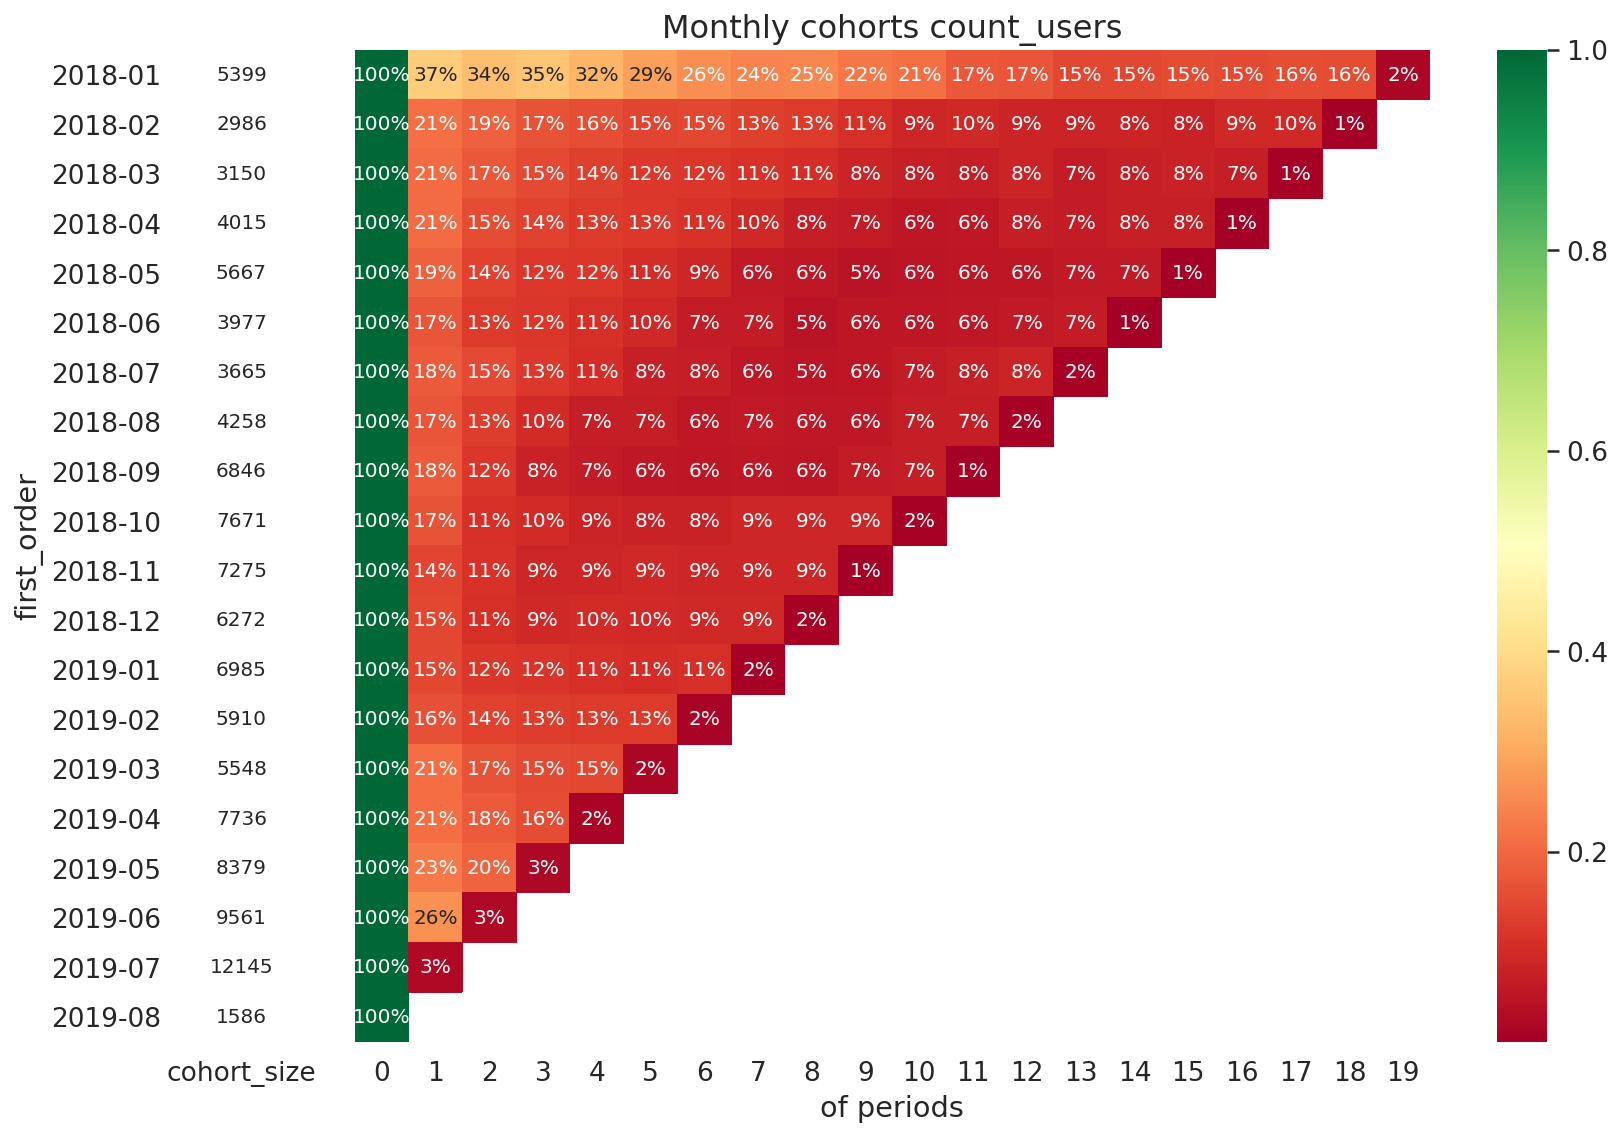

In [54]:
draw_cohort('count_users')

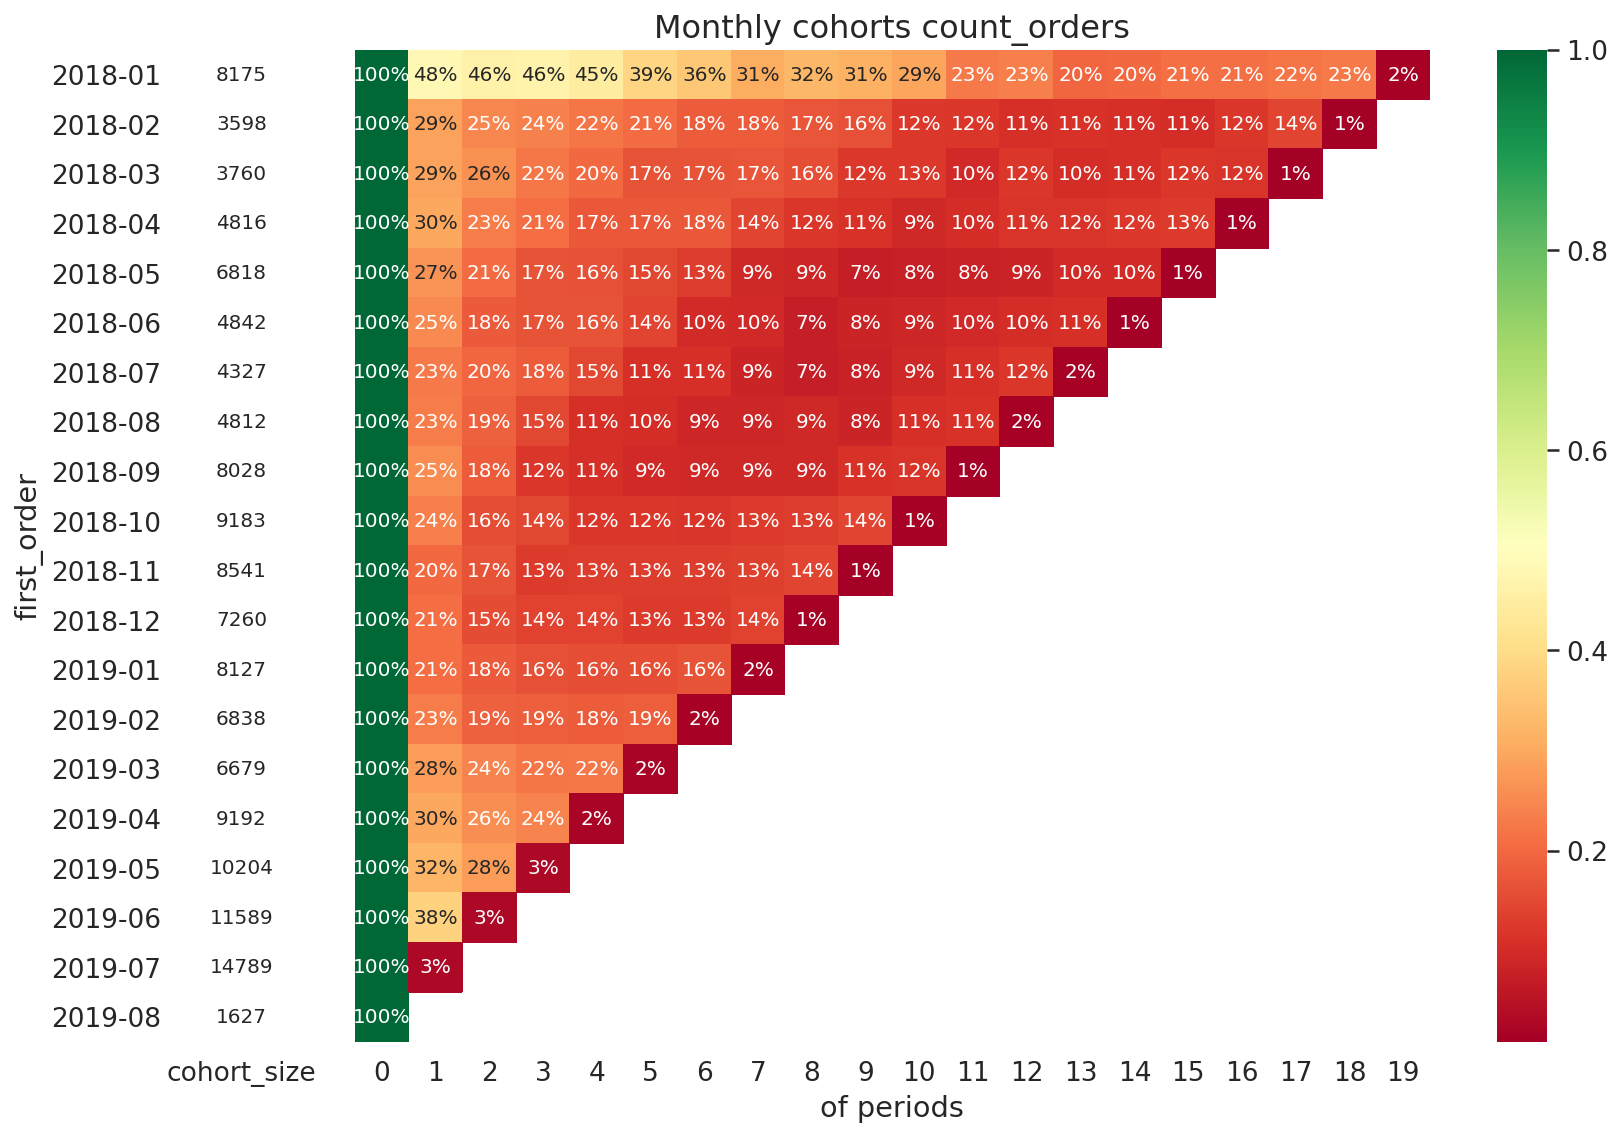

In [55]:
draw_cohort('count_orders')

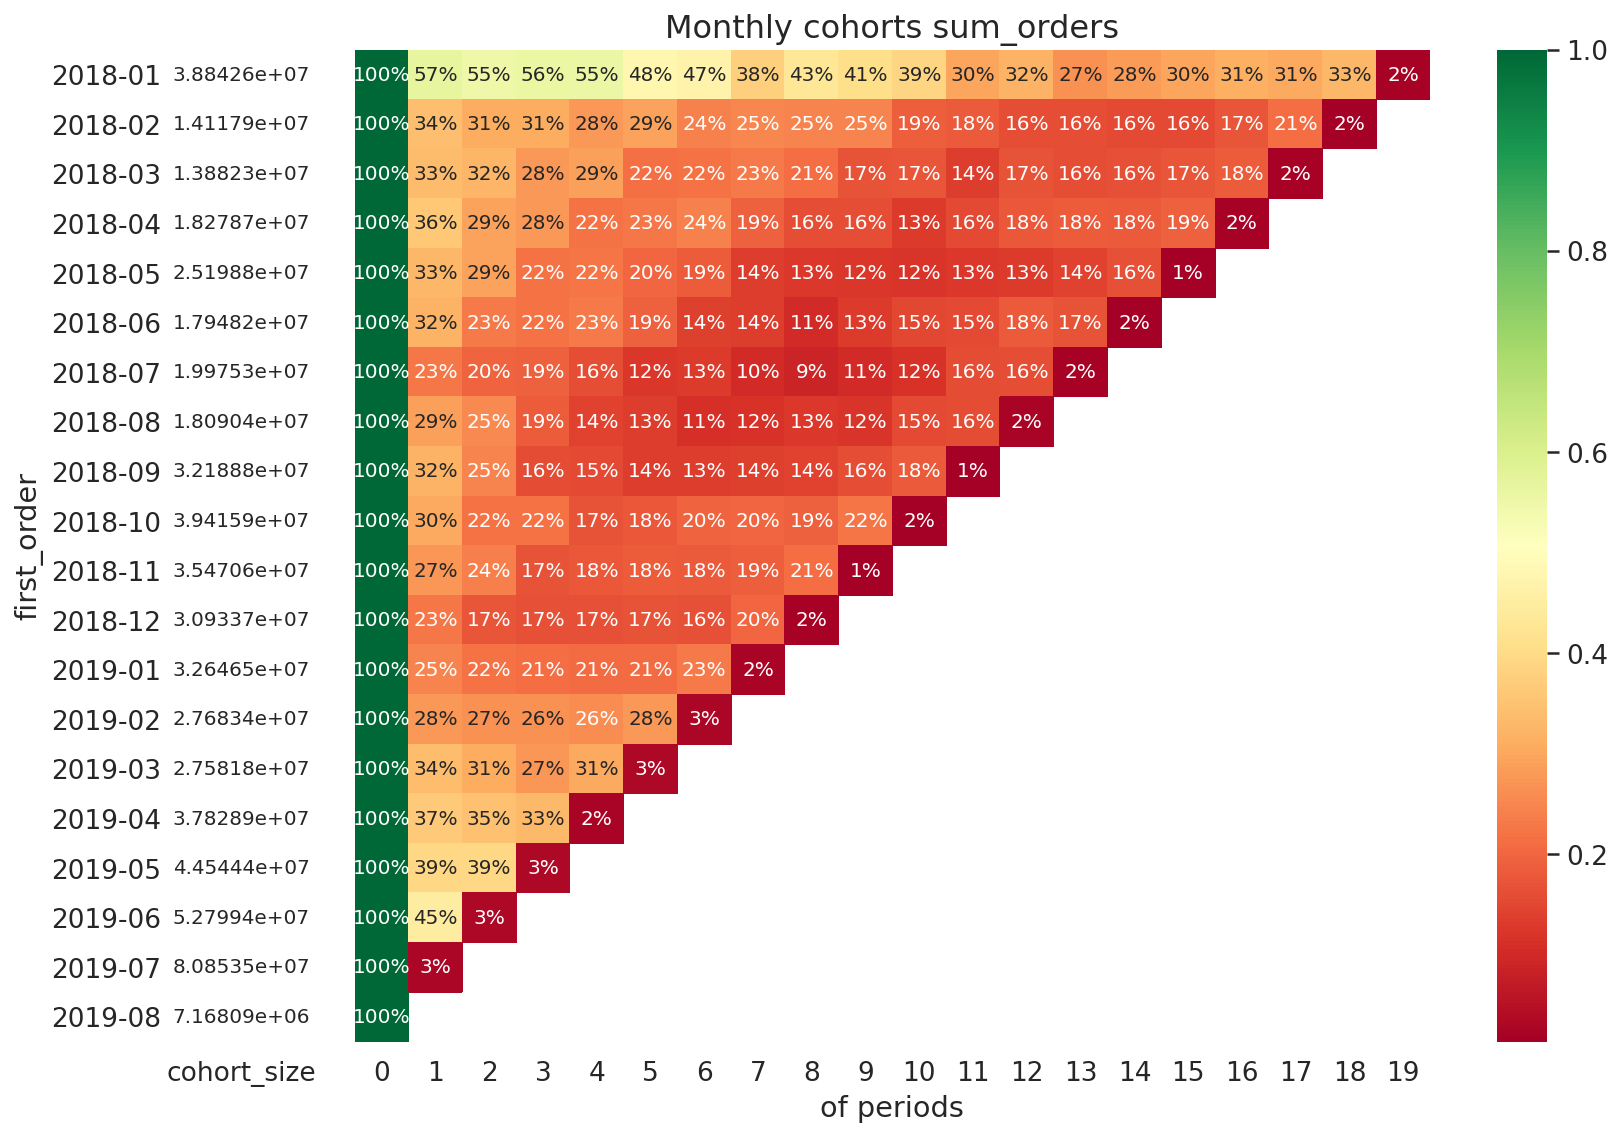

In [56]:
draw_cohort('sum_orders')

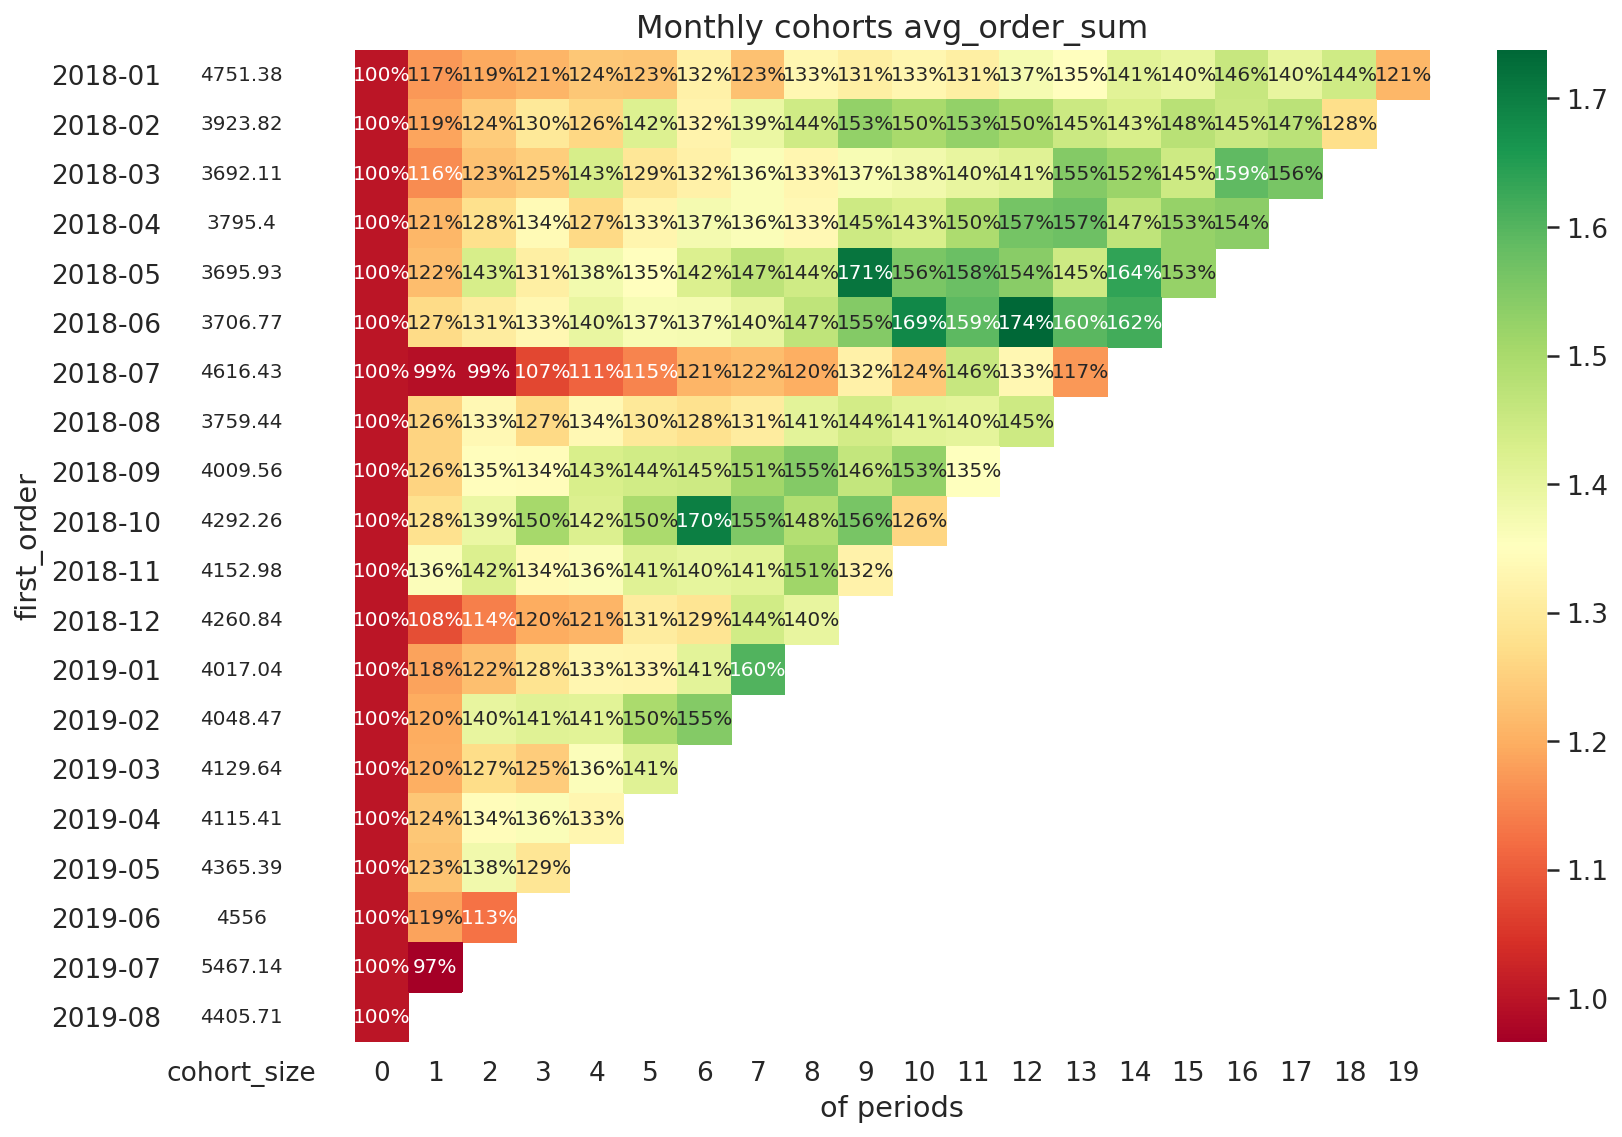

In [57]:
draw_cohort('avg_order_sum')

In [58]:
# Count LTV
df_cohort['cum_sum_orders'] = df_cohort['sum_orders'].cumsum()
df_cohort['ltv'] = df_cohort['cum_sum_orders']/df_cohort['count_users']
ltv_by_mounth_using_service = df_cohort.groupby('period_number')['ltv'].sum()

ltv_by_mounth_using_service = ltv_by_mounth_using_service/1000000

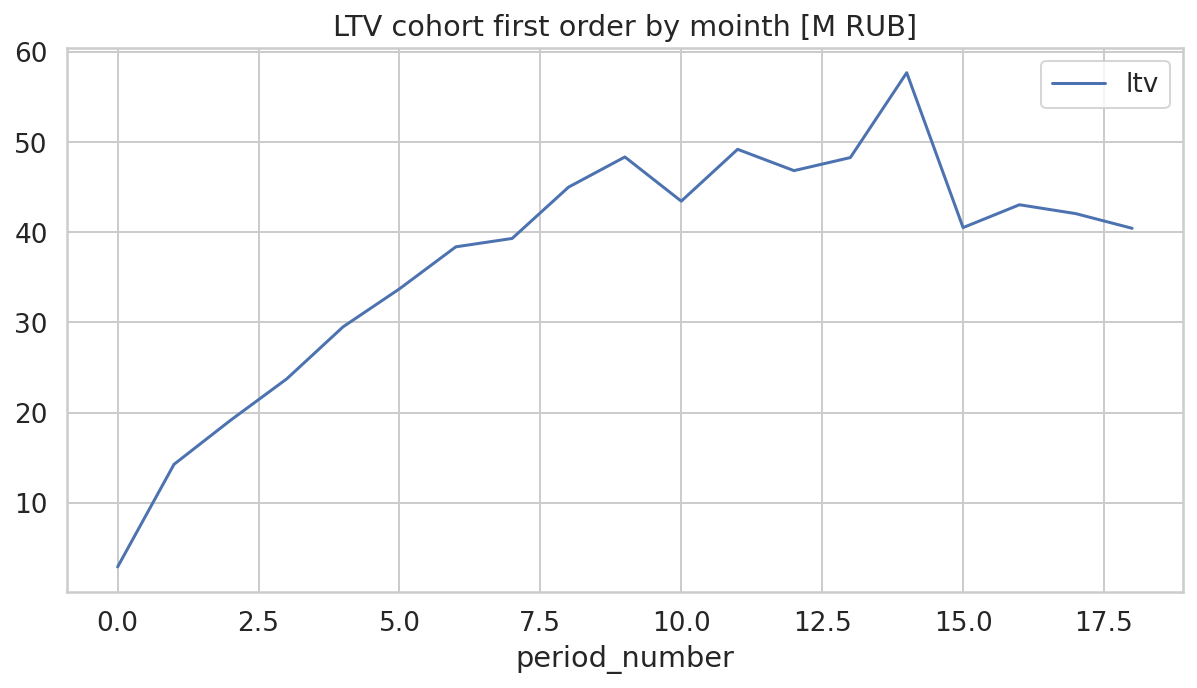

In [59]:
# Plot LTV
fig = plt.figure(figsize=(10,5))
ltv_by_mounth_using_service[:-1].plot()
plt.title('LTV cohort first order by mointh [M RUB]')
plt.legend();

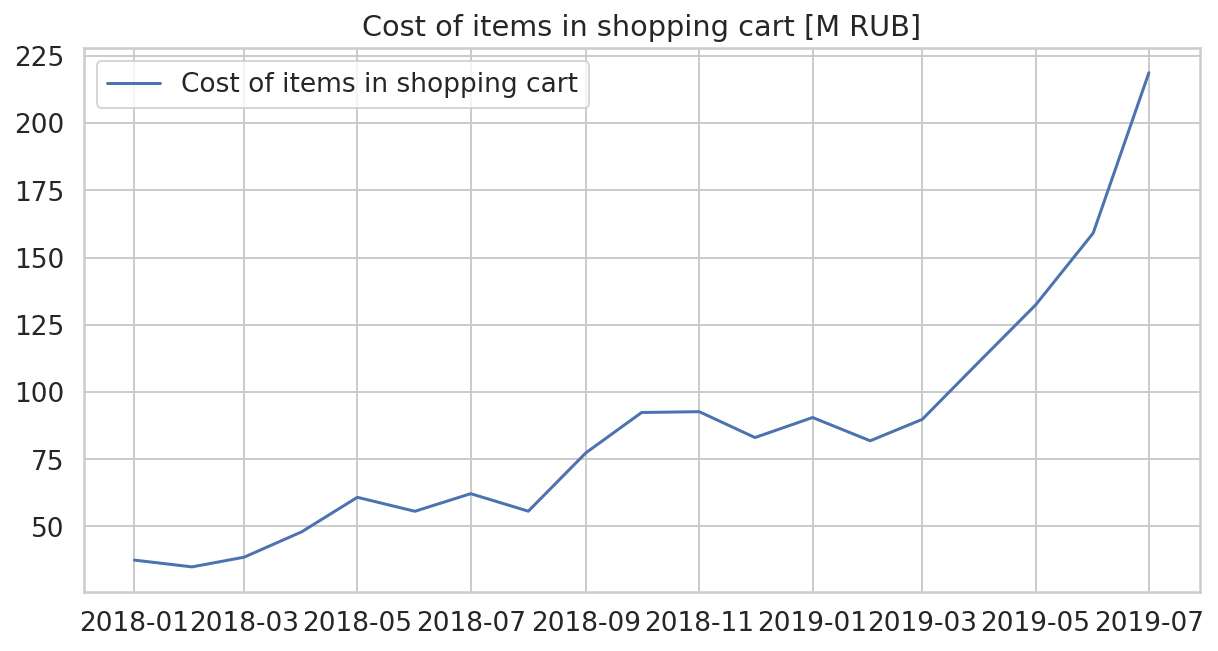

In [60]:
# Check seasonality
orders_['created_at_month'] = orders_['created_at'].dt.to_period('M')
seasonality = orders_.groupby('created_at_month')[['item_total']].sum()
seasonality = seasonality[:-1]


fig = plt.figure(figsize=(10,5))
plt.plot(seasonality.index.to_timestamp(), seasonality/1000000, label = 'Сost of items in shopping cart')
plt.title('Сost of items in shopping cart [M RUB]')
plt.legend();

##  Задание 1

In [61]:
#    Метрики:
# 1. Приход, расход, прибыль в деньгах (Лучше на одном графике, например недельном. Лучше с показателями предыдущей недели для сравнения)
# 2. Полученные заказы, доставленные заказы, отмененные заказы в количестве заказов (предыдущие рекомендации сохраняются)
# 3. Эффективность рекламных каналов (как онлайн так и оффлайн, если имеются, предыдущие рекомендации сохраняются)
# 4. Динамика по портнерам площадки (количество ритейлеров, магазинов, городов, предыдущие рекомендации сохраняются)
# 5. Динамика по клиентам площадки (количество новых, вернувшихся, ушедших клиентов, предыдущие рекомендации сохраняются)

## Задание 2

In [66]:
# 1.  Данные не синтетические, непрерывные (1.6 года), недостающих фрагментов мене 0.013 %. Организация таблиц интуитивно-понятная, кроме 
#     отсутствия таблицы с кодами городов.
# 2.  Сильная корреляция веса и количества говорит о фасовке, в данном случае примерно 0.625 кг/шт - средний вес единицы (вероятно с упаковкой).
#     Сильная корреляция стоимости товаров и количества говорит об однородности товаров по стоимости. Товары одного ценового сегмента, в данном
#     случае 188 руб/кг, 117 руб/шт. Для простоты анализа сделаем предположение, что это импортное баночное пиво.
# 3.  Сумма скидок 2.68 % от общей стоимости заказа или  45 М из 1684 M RUB.
# 4.  Лучшие населенные пункты для расширеня ритейлеров по количеству заказов из них: Развилка, Балашиха, Долгопрудный (если считать  
#     Нижний Новгород и Бор одним городом), исключая Москву доля заказов которой - 85%.
# 5.  Только 4% междугородних заказов. 0.34% заказов составные (один заказ собирают в нескольких магазинах).
# 6.  Самая крупная ритейлерская сеть обеспечивает 97% от всех заказов, 86% из которых по Москве, 14% - по России.
# 7.  Около 80% пользователей не совершают покупку в следующем за месяцем первой покупкой месяце. Когорта которая сделала первую покупку 
#     в январе 2018 отличается - 37% вернулись в следующем месяце. Годовое удержание по этой когорте 17%, против 8% в среднем у остальных.
# 8.  На графике стоимости товаров относительно времени не заметна явная сезонность, кроме всплеска продаж летом 2019. С другой стороны
#     На когортах по сумме заказов, количеству пользователей и количеству заказов явно видно затухание попадающее на лето-осень 2018.
#     Возможно, это связано с тем, что старые пользователи сервиса предпочитают пить "пиво" вне дома в летнее время.
# 9.  Средний чек, наоборот показывает активный рост. Особенно это каксается когорт пришедших на сервис с марта по июнь 2018. Возможно, часть 
#     этих данных можно объяснить инфляцией, которая составила 14% пунктов за рассматриваемый период. С другой стороны это объясняется
#     увеличением количества проданных тваров.
# 10. Рост LTV после года с небольшим переходит в падение. Возможно, поощрение для пользователя, приуроченное к годовщине пользования сервисом 
#     исправит ситуацию.
# 12. Отмененные и замененные товары.
#     Как я понимаю, проблема в том, что на момент сборки заказа, товара уже нет в наличаи. Если так, то возможные варианты решения следующие: 
#     a) Можно попробовать прогнозировать спрос, соотносить его с остатками и снимать товар с продажи заранее, если для бизнеса не критично
#     не продовать позицию "под ноль" через онлайн. Учитывая, что id товаров увеличиваются во времени и старые id не появляются в списках
#     замен и отмен более свежих заказов, возможно, карточка товара заводится занова, если товар поступил в продажу на сайт повнорно после того,
#     как ранее закончился. Если это так, это можно исправить - что даст большую свободу в прогнозировании спроса. Если нет, возможно,
#     лучше будет  кластеризовать товар, и прогнозировать спрос по усредненным показателям кластера.
#     б) Альтернативный способ уменьшить количество отмененных товаров - это увеличить количество замененных. Те помочь пользователю в замене
#     отсутствующего товара на аналог посредством рекомендательной системы, например.
#     в) Как вариант, можно проверять наличие товара в других магазинах, если он закончился в конкретном. Далее осуществлять внутреннее 
#     перемещение таких товаров, или иначе обеспечивать соединенение товаров в один заказ до получения его пользователем.
#     г) Проверить оперативность внесения данных об отсутствии товара на сайт.

In [63]:
# count month
19/12

1.5833333333333333

In [64]:
# all promo %
(orders_['delivery_promo_sum'].sum() - orders_['promo_total'].sum())/orders_['full_cost'].sum()*100

2.6841163034253346

In [65]:
# inflation
100 - 56/65*100

13.84615384615384